In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from parsers import LIUMSegments

In [3]:
def read_ctm_by_segments(ctm_file, segments):
    """
    Takes words from the CTM file and looks them up in the segments.
    Probabilities for the words get stored under the video name and the interval of the segment.
    """
    probs = defaultdict(lambda: defaultdict(list))
    for line in open(ctm_file):
        video, channel, start_time, duration, hypothesis, probability = line.split(" ")
        start_time = float(start_time.strip())
        segment = segments.get(video, sec=start_time)
        interval = pd.Interval(left=segment.start, right=segment.start+segment.length)
        probs[video][interval].append(1.0 - float(probability.strip()))
    return probs

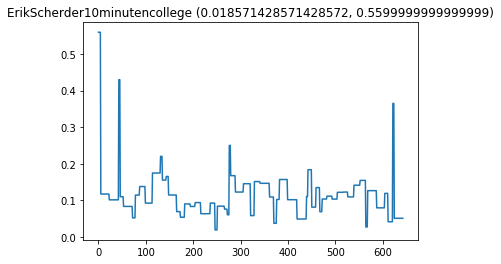

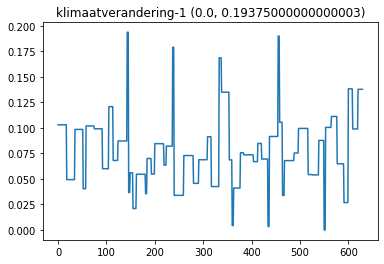

In [4]:
for entry in os.scandir("data"):

    if not entry.name.endswith(".seg"):
        continue

    segments = LIUMSegments()
    segments.load(entry.path)

    tail, head = os.path.split(entry.path)
    file, ext = os.path.splitext(head)
    ctm_file_path = os.path.join(tail, file + ".ctm")

    # Here we're getting the probabilities for words sorted by segments of videos.
    ctm = read_ctm_by_segments(ctm_file_path, segments)
    # Now we loop over the segments and plot the average probability of a segment 
    # over the length of a segment in seconds
    for video, segment_probs in ctm.items():
        title = video
        # Repeat the average probability of a segment for the duration of a segment
        probs = []
        for interval, interval_probs in segment_probs.items():
            average_prob = np.mean(interval_probs)
            for ix in range(interval.left, interval.right, 100):
                probs.append((ix, average_prob,))
        # Sorting the probabilities by their times and then plotting them
        probs.sort(key=lambda item: item[0])
        probs = [item[1] for item in probs]
        title += f" ({min(probs)}, {max(probs)})"
        plt.plot(range(0, len(probs)), probs)
        plt.title(title)
        plt.show()